## <font color='darkblue'>Introduction</font>
([article source](https://medium.com/analytics-vidhya/implementing-a-gan-in-keras-d6c36bc6ab5f))
> [GANs], and the variations that are now being proposed is the most interesting idea in the last 10 years in ML, in my opinion. -Yann LeCun

![image1](Images/1.gif)
<br/>

[**Generative Adversarial Networks**](https://en.wikipedia.org/wiki/Generative_adversarial_network), or GANs for short, are some of the most potent tools a machine learning practitioner can use. GANs are capable of doing everything from super-resolution in images, to image translation, to facial manipulation, to medicine creation, to much, much more.

![image1](Images/2.PNG)
<br/>

In this article, we will cover both the intuition behind how GANs work, and how we can implement them in Keras. Specifically, we will be first implementing a **fully-connected GAN** (<font color='brown'>FCGAN</font>) for [**MNIST**](https://en.wikipedia.org/wiki/MNIST_database), then later improving that into a **deep convolutional GAN** (<font color='brown'>DCGAN</font>) for a class of [**CIFAR-10**](https://en.wikipedia.org/wiki/CIFAR-10).

The completed code we will be creating in this tutorial is available on my GitHub, [here](https://github.com/EvolvedSquid/tutorials/tree/master/gans).

## <font color='darkblue'>How GANs Work</font>
**A GAN works by battling two neural networks, a <font color='darkblue'>generator</font> and a <font color='darkblue'>discriminator</font>, against each other in an attempt to learn the probability distribution of a dataset.** The **<font color='darkblue'>generator</font>**, often written as `G`, attempts to create realistic-looking images. It does this by taking some noise vector, `z`, and applying a series of calculations on it; these calculations usually take the form of a neural network. The result is $G(z)$, an image that is the generator’s attempt to fool the **<font color='darkblue'>discriminator</font>**; On the other hand, the discriminator, `D`, attempts to classify real and fake images. Images are considered “fake” if the generator creates them, and “real” if they were selected from the dataset. `x` represents the input image, and $D(x)$ represents the probability that the discriminator believes `x` is real.

![image](Images/3.PNG)
<center>Adapted from <a href='https://www.slideshare.net/ckmarkohchang/generative-adversarial-networks'>source</a></center> <br/>
<br/>

**As the discriminator improves at classifying real vs. fake images, it forces the generator to improve at creating images.** **The goal is for the generator to become so adept at creating images that the generated images are indistinguishable from reality**, meaning even a perfect discriminator would never be sure about the validity of the images, i.e. $D(x) = 0.5$.

If you would like a much more detailed explanation of the math behind GANs, I would recommend reading the [original paper](https://arxiv.org/pdf/1406.2661.pdf) by Goodfellow et al.

## <font color='darkblue'>Putting it into Practice</font>
* [**Setting Everything Up**](#sect2_1)
* [**Creating the Generator**](#sect2_2)
* [**Creating the Discriminator**](#sect2_3)
* [**Building the GAN**](#sect2_4)
* [**Training the GAN**](#sect2_5)
* [**Training Result**](#sect2_6)

Training a GAN is a lot harder than understanding how it works. While I will walk through the Keras code to create a simple GAN, I recommend following roughly what I do instead of copying it verbatim. **Finding the correct architecture for GANs is a challenging task, and the best way to gain intuition about building models is through trial and error.** ([original notebook](https://github.com/EvolvedSquid/tutorials/blob/master/gans/dcgan-tutorial.ipynb))

<a id='sect2_1'></a>
### <font color='darkgreen'>Setting Everything Up</font>
Let’s start by defining a few hyperparameters:

In [2]:
from keras.optimizers import Adam
from keras.models import load_model
import numpy as np
import os

np.random.seed(10)
noise_dim = 100
batch_size = 16
steps_per_epoch = 3750
epochs = 10
save_path = 'fcgan-images'
img_rows, img_cols, channels = 28, 28, 1
optimizer = Adam(0.002, 0.5)
gan_model_serialized_path = "mnist_gan_model.h5"
gan_gen_model_serialized_path = "mnist_gan_model_gen.h5"
gan_dsm_model_serialized_path = "mnist_gan_model_dsm.h5"

* We are using `np.random.seed` for consistent results.
* `noise_dim` specifies the length of the random noise vector, `z`.
* We perform 3750 steps per epoch as 60000, the number of examples in [**MNIST**](https://en.wikipedia.org/wiki/MNIST_database), divided by 16, the batch size, is 3750.
* `save_path` specifies where we will be training snapshots of the images generated during training. We won’t be using this until later on.
* Initialize optimizer [**Adam**](https://keras.io/api/optimizers/adam/) with learning `rate=0.002` and `beta_1=0.5`

After setting the hyperparameters, we can load the dataset of our choice.

In [59]:
from keras.datasets import mnist
import os

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train.astype(np.float32) - 127.5) / 127.5
x_train = x_train.reshape(-1, img_rows*img_cols*channels)

if not os.path.isdir(save_path):
    os.mkdir(save_path)

In [13]:
# 784 = 28 * 28
x_train.shape

(60000, 784)

Above, we are also making a directory to save the images generated during training, if it does not already exist.

As we implement an **FCGAN**, we will be loading mnist into a flat shape; however, we will replace this when we implement a **DCGAN**. If we were to generate, let’s say faces, we would replace this section with the code to load those faces into the same format.

<a id='sect2_2'></a>
### <font color='darkgreen'>Creating the Generator</font>
Now it’s time to **define a function to create the generator. This is the part of the model that is most creative**, and I highly encourage you to invent your own architectures.

In [60]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.advanced_activations import LeakyReLU

def create_generator(noise_dim=noise_dim, optimizer=optimizer):
    if os.path.isfile(gan_gen_model_serialized_path):
        return load_model(gan_gen_model_serialized_path)
    
    generator = Sequential()
    
    generator.add(Dense(256, input_dim=noise_dim))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(img_rows*img_cols*channels, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

This generator takes an input of dimension `noise_dim`, and through multiple sets of [**Dense**](https://keras.io/api/layers/core_layers/dense/) layers followed by [LeakyReLU](https://keras.io/layers/advanced-activations/#leakyrelu) activations, it outputs a flat version of an image.
![image](Images/4.PNG)
<center><a href='https://medium.com/@himanshuxd/activation-functions-sigmoid-relu-leaky-relu-and-softmax-basics-for-neural-networks-and-deep-8d9c70eed91e'>image source</a></center>
<br/>
<br/>

**We must <font color='darkred'>use the tanh activation</font> for the final layer to stay consistent with our normalization of the images earlier, and for better results.**
![image](Images/5.PNG)
<center><a href='https://mc.ai/complete-guide-of-activation-functions/'>image source</a></center>
<br/>
<br/>

The optimizer we use is also very important. **If we had a learning rate of just a bit too high, the model would enter <font color='darkblue'>mode collapse</font>, where it would no longer be able to improve, and would produce garbage images.**

<a id='sect2_3'></a>
### <font color='darkgreen'>Creating the Discriminator</font>
Next up, the discriminator. Again, I recommend playing around with the architecture and seeing what results you get.

In [61]:
def create_discriminator(optimizer=optimizer):
    if os.path.isfile(gan_dsm_model_serialized_path):
        return load_model(gan_dsm_model_serialized_path)
        
    discriminator = Sequential()
     
    discriminator.add(Dense(1024, input_dim=img_rows*img_cols*channels))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    discriminator.trainable = False
    return discriminator

There isn’t anything too special about this discriminator. It takes in a flattened image, passes it through some sets of [**Dense**](https://keras.io/api/layers/core_layers/dense/) and [**LeakyReLU**](https://keras.io/api/layers/activation_layers/leaky_relu/) layers, then spits out a single probability, $D(x)$, squashed to between 0 and 1 with a [sigmoid activation](https://en.wikipedia.org/wiki/Sigmoid_function).

<a id='sect2_4'></a>
### <font color='darkgreen'>Building the GAN</font>
**With the <font color='darkblue'>discriminator</font> and <font color='darkblue'>generator</font> in place, we can create the combined GAN model.** First, we can initialize the discriminator and generator with:

In [62]:
discriminator = create_discriminator()
discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                

In [63]:
generator = create_generator()
generator.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 784)              

Then, we can use a little trick; we can set `discriminator.trainable` to False. Why would we want to do this?

**Well, we aren’t going to be training the generator model directly — we are going to be combining the generator and discriminator into a single model, then training that.** This allows the generator to understand the discriminator so it can update itself more effectively.

Setting `discriminator.trainable` to False will only affect the copy of the discriminator in the combined model. This is good! If the copy of the discriminator in the combined model were trainable, it would update itself to be worse at classifying images. We’ll look more into this when we train the model.

**To combine the generator and discriminator, we will be calling the discriminator on the output of the generator.**

In [64]:
from keras.layers import Input
from keras.models import Model

gan_input = Input(shape=(noise_dim,))
fake_image = generator(gan_input)

gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)
gan.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_5 (Sequential)    (None, 784)               1486352   
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


This gives us a model that takes some random noise, `z`, as input, and **returns how convinced the discriminator is that the generator’s images are real, $D(G(z))$.** Specifically, it has an input shape of `(None, 100)` and an output shape of `(None, 1)`. The 100 in the input shape comes from `noise_dim`.

<a id='sect2_5'></a>
### <font color='darkgreen'>Training the GAN</font>
Now comes the time to put the GAN training into action. **Since we are training two models at once, the discriminator and the generator, we can’t rely on Keras’ .`fit` function. Instead, we have to manually loop through each epoch and fit the models on batches:**
```python
for epoch in range(epochs):
    for batch in range(steps_per_epoch):
        ...
```

Inside of the nested-loop, we can create our `fake_x` data:
```python
noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
fake_x = generator.predict(noise)
```
<br/>

We do this by first sampling some random noise from a normal distribution, then getting the generator’s predictions on the noise. The `noise` variable is the code equivalent of the variable `z`, which we discussed earlier.

We can create our `real_x` data by sampling random elements from our `x_train` that we loaded earlier:
```python
real_x = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
```
<br/>

After creating both the real and fake data input data for our discriminator, we can concatenate them into a single variable:
```python
x = np.concatenate((real_x, fake_x))
```
<br/>

Then, we can set up our `y_data` for the discriminator:
```python
disc_y = np.zeros(2*batch_size)
disc_y[:batch_size] = 0.9
```
<br/>

We are setting half of the `disc_y` to 0.9 to correlate with the `real_x` data.

<b><font size='3ptx' color='darkred'>Why 0.9 instead of 1?</font></b><br/>
<font color='darkblue'>**Label smoothing**</font>, the act of replacing “hard” values (<font color='brown'>i.e., 1 or 0</font>) with **“soft” values** (<font color='brown'>i.e., 0.9 or 0.1</font>) **for labels, often helps the discriminator train by reducing <font color='darkblue'>sparse gradients</font>.** This technique was proposed for GANs in [Salimans et al. 2016](https://arxiv.org/pdf/1606.03498.pdf). Label smoothing is usually most effective when **only applied to the 1's of a y-data, which is then called “one-sided label smoothing”**.

Finally, we can train the discriminator on a batch:
```python
d_loss = discriminator.train_on_batch(x, disc_y)
```
<br/>

Make sure to store the loss produced by training on the batch into a variable, so that we can print it later. Next, we can train the generator with only two more lines:
```python
y_gen = np.ones(batch_size)
g_loss = gan.train_on_batch(noise, y_gen)
```
<br/>

In essence, what **these two lines are telling the generator to do is to make the discriminator think the image you produce is real, when given some random noise.**

<b><font size='3ptx' color='darkred'>Take a second to think about what’s going on under the hood here.</font></b><br/>
Because we connected the two models into one, the generator understands how the discriminator is categorizing its images and knows how to update its technique accordingly. **By default, this would also update the weights of the discriminator to help the generator, but since we set `discriminator.trainable`, to False, it doesn’t — forcing the generator to create more realistic images.**

That idea seems incredible to me.

Inside of the `epoch` loop, but outside the `steps_per_epoch` loop, you may want to print the losses of the generator and discriminator. You can do that with something along the lines of:
```python
print(f'Epoch: {epoch} \t Discriminator Loss: {d_loss} \t\t Generator Loss: {g_loss}')
```
<br/>
And as a recap, here is the full training loop we just implemented:

In [66]:
def start_training(epochs=epochs):
    for epoch in range(epochs):
        for batch in range(steps_per_epoch):
            noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
            fake_x = generator.predict(noise)

            real_x = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
        
            x = np.concatenate((real_x, fake_x))

            disc_y = np.zeros(2*batch_size)
            disc_y[:batch_size] = 1.0

            d_loss = discriminator.train_on_batch(x, disc_y)

            y_gen = np.ones(batch_size)
            g_loss = gan.train_on_batch(noise, y_gen)

        print(f'Epoch: {epoch} \t Discriminator Loss: {d_loss:.03f} \t\t Generator Loss: {g_loss:.03f}')

In [65]:
%time start_training(epochs=3)

Epoch: 0 	 Discriminator Loss: 0.000 		 Generator Loss: 54.272
Epoch: 1 	 Discriminator Loss: 0.000 		 Generator Loss: 15.948
Epoch: 2 	 Discriminator Loss: 0.000 		 Generator Loss: 14.940
Wall time: 12min 43s


In [44]:
r'''
gan_model_serialized_path = "mnist_gan_model.h5"
gan_gen_model_serialized_path = "mnist_gan_model_gen.h5"
gan_dsm_model_serialized_path = "mnist_gan_model_dsm.h5"
'''
discriminator.save(gan_dsm_model_serialized_path)
generator.save(gan_gen_model_serialized_path)
gan.save(gan_model_serialized_path)

<a id='sect2_6'></a>
### <font color='darkgreen'>Training Results</font>
**To visualize our results**, we can implement a quick function that will visualize a 10x10 plot of generated images:

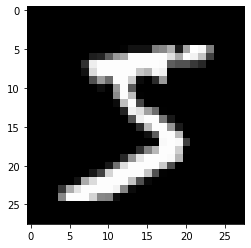

In [67]:
plt.imshow(x_train[0].reshape((img_rows, img_cols)), cmap='gray')

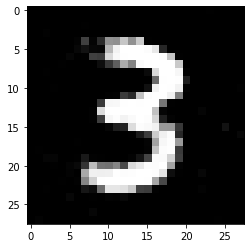

In [20]:
noise = np.random.normal(0, 1, size=(2, noise_dim))
generator = load_model('dcgenerator.h5')
generated_images = generator.predict(noise)
plt.imshow(generated_images[0].reshape((img_rows, img_cols)), cmap='gray')

In [22]:
import matplotlib.pyplot as plt

def show_images(noise):
    generated_images = generator.predict(noise)
    plt.figure(figsize=(10, 10))
    
    for i, image in enumerate(generated_images):
        plt.subplot(10, 10, i+1)
        if channels == 1:
            plt.imshow(image.reshape((img_rows, img_cols)), cmap='gray')
        else:
            plt.imshow(image.reshape((img_rows, img_cols, channels)))
            
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

Then we can show the images with:

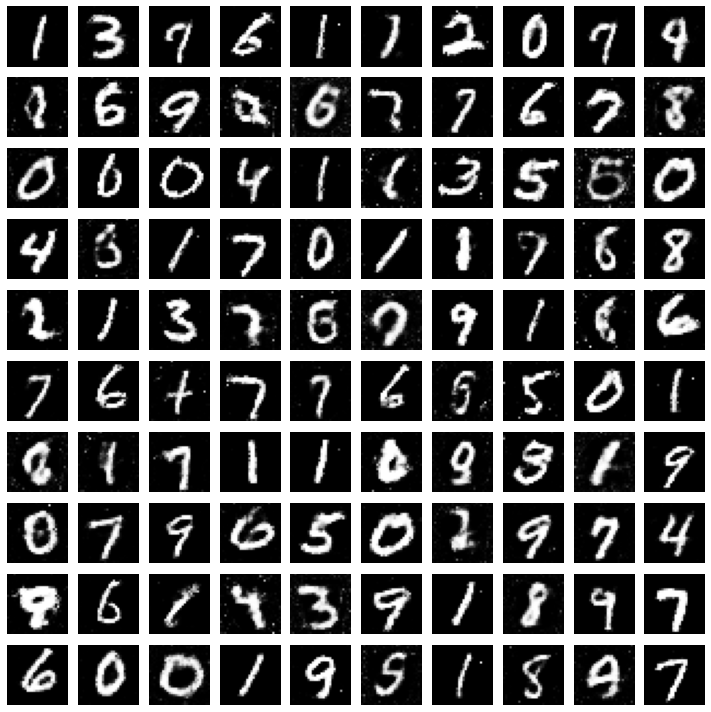

In [23]:
noise = np.random.normal(0, 1, size=(100, noise_dim))
show_images(noise)

After 10 epochs of training with a batch size of 16 and a steps per epoch size of 3750, above are the results I got.

Not horrible, but there’s room to improve.
Furthermore, if you try to run this on CIFAR-10, you will most likely get unusable results. An **FCGAN** won’t cut it. To fix that, we can use a **DCGAN**.

## <font color='darkblue'>DCGAN</font>
* [**Data Pre-processing**](#sect3_1)
* [**The Generator**](#sect3_2)
* [**The Discriminator**](#sect3_3)
* [**Training Results**](#sect3_4)

The only difference between an FCGAN and a DCGAN is explained in their names. A fully-connected GAN uses fully-connected layers, also known as dense layers, to generate and classify images, while a **deep convolutional GAN uses convolutional layers to do the same task**. ([source notebook](https://github.com/EvolvedSquid/tutorials/blob/master/gans/fcgan-tutorial.ipynb))

<a id='sect3_1'></a>
### <font color='darkgreen'>Data Pre-processing</font>
To account for the new architecture of the DCGAN, we also **have to change how we are reshaping `x_train`**. So we can change:
```python
x_train = x_train.reshape(-1, img_rows*img_cols*channels)
```
<br/>

to
```python
x_train = x_train.reshape((-1, img_rows, img_cols, channels))
```
<br/>

I am also changing:
```python
(x_train, y_train), (x_test, y_test) = mnist.load_data()
```
<br/>

to
```python
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
```
<br/>

And of course `img_rows, img_cols, channels = 28, 28, 1` to: `img_rows, img_cols, channels = 32, 32, 3`.

**For the sake of computing time, I would recommend only using a single class of CIFAR-10.** Let’s choose cats, class three, since that’s what we need more of on the internet. We can do this with:
```python
x_train = x_train[np.where(y_train == 3)[0]]
```
<br/>

[**np.where**](https://numpy.org/doc/stable/reference/generated/numpy.where.html) returns the indices of an array where an evaluation, e.g. `y_train == 3`, is true.

<a id='sect3_2'></a>
### <font color='darkgreen'>The Generator</font>
For **DCGAN**, we have a much more advanced generator architecture.

In [20]:
from keras.initializers import RandomNormal
from keras.layers import Dense, Conv2D, Conv2DTranspose, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential

def create_generator(noise_dim=noise_dim):
    generator = Sequential()
    
    # Starting size
    d = 4
    generator.add(Dense(d*d*256, kernel_initializer=RandomNormal(0, 0.02), input_dim=noise_dim))
    generator.add(LeakyReLU(0.2))
    # 4x4x256
    generator.add(Reshape((d, d, 256)))
    
    # 8x8x128
    generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    generator.add(LeakyReLU(0.2))
    
    # 16x16*128
    generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    generator.add(LeakyReLU(0.2))
    
    # 32x32x128
    generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    generator.add(LeakyReLU(0.2))
    
    # 32x32x3
    generator.add(Conv2D(channels, (3, 3), padding='same', activation='tanh', kernel_initializer=RandomNormal(0, 0.02)))
    
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

This model starts with a small image, which is slowly scaled up with [**Conv2DTranspose**](https://keras.io/api/layers/convolution_layers/convolution2d_transpose/) layers. Growing GAN images is an incredible technique developed by NVIDIA, and the generator architecture above mimics a greatly simplified version of it.

You can read the full paper on progressive growing of GANs [here](https://arxiv.org/pdf/1710.10196.pdf).

In this model, we are also initializing the weights using the [**RandomNormal**](https://keras.io/initializers/#randomnormal) initializer. This tends to give better results, and is in no way limited to **DCGANs**.

<a id='sect3_3'></a>
### <font color='darkgreen'>The Discriminator</font>
The best image classifier architectures are also often the best discriminator architectures.

In [13]:
from keras.initializers import RandomNormal
from keras.layers import Dense, Conv2D, Flatten, Reshape, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential

def create_descriminator():
    discriminator = Sequential()
    
    discriminator.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=RandomNormal(0, 0.02), input_shape=(img_cols, img_rows, channels)))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Conv2D(256, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Flatten())
    discriminator.add(Dropout(0.4))
    discriminator.add(Dense(1, activation='sigmoid', input_shape=(img_cols, img_rows, channels)))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

Because of that, this discriminator looks like pretty much every standard Keras image classifier you’ve seen.

<a id='sect3_4'></a>
### <font color='darkgreen'>Training Results</font>
Running this on a class of CIFAR-10 gives much better results than a simple FCGAN ever could.
![image](Images/6.PNG)
<br/>

An improved architecture would allow for higher quality images. A popular improvement on a vanilla DCGAN is to incorporate residual blocks from the [ResNet paper](https://arxiv.org/pdf/1512.03385.pdf). This is seen in the U-Net generator we implement in [my article on the advanced technique, CycleGAN](https://medium.com/analytics-vidhya/transforming-the-world-into-paintings-with-cyclegan-6748c0b85632).

You may also want to visualize the training process, meaning that you could call the visualization function we implemented earlier inside of your training loop, for every 10 epochs or so. If you do this, I would recommend creating some constant noise in the beginning, so you can see how the GAN changes over time.

Your new training loop would look something like:

In [14]:
def train_gan_cifar10():
    static_noise = np.random.normal(0, 1, size=(100, noise_dim))
    
    for epoch in range(epochs):
        for batch in range(steps_per_epoch):
            noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
            real_x = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            fake_x = generator.predict(noise)

            x = np.concatenate((real_x, fake_x))

            disc_y = np.zeros(2*batch_size)
            disc_y[:batch_size] = 0.9

            d_loss = discriminator.train_on_batch(x, disc_y)

            y_gen = np.ones(batch_size)
            g_loss = gan.train_on_batch(noise, y_gen)

        print(f'Epoch: {epoch} \t Discriminator Loss: {d_loss} \t\t Generator Loss: {g_loss}')
        if epoch % 10 == 0:
            show_images(static_noise, epoch)

Furthermore, inside of `show_images` you could save the figure with `plt.figsave(file)`, making the `show_images` function into:

In [16]:
import matplotlib.pyplot as plt

def show_images(noise, epoch=None):
    generated_images = generator.predict(noise)
    plt.figure(figsize=(10, 10))
    
    for i, image in enumerate(generated_images):
        plt.subplot(10, 10, i+1)
        if channels == 1:
            plt.imshow(image.reshape((img_rows, img_cols)), cmap='gray')
        else:
            plt.imshow(image.reshape((img_rows, img_cols, channels)))
        plt.axis('off')
    
    plt.tight_layout()
    
    if epoch != None:
        plt.savefig(f'{save_path}/gan-images_epoch-{epoch}.png')
    plt.show()

If you would like, you can turn the directory where these images were saved into a GIF with:

In [18]:
from PIL import Image, ImageDraw

def turn_images_into_gif():
    frames = []
    for image in os.listdir(save_path):
        frames.append(Image.open(save_path + '/' + image))
    frames[0].save('gan_training.gif', format='GIF', append_images=frames[1:], save_all=True, duration=400, loop=0)

We sort the images by epoch number using:
```python
sorted(image_names, key=lambda name: int(''.join(i for i in name if i.isdigit())))
```
<br/>
This removes all non-numeric characters from the file path, converts it to an integer, and sorts it in ascending order after that.

![image](Images/2.gif)
<br/>

If you want a detailed explanation of creating GIFs in Python, I would recommend [this article](https://blog.zhaytam.com/2018/08/21/creating-gifs-using-python-pillow/).

## <font color='darkblue'>Conclusion</font>
In this article, we covered the basics of implementing a GAN in Keras. I hope to create a whole series regarding the immense capabilities of GANs and how we can implement them in simple Keras (<font color='brown'>and maybe a bit of TensorFlow</font>) code.

Also, please be aware that it takes a lot of computing power to train a GAN. Don’t be afraid to run a model for hours, or even days, at a time. If you do not have enough computing power to train a GAN, I would recommend using a [Kaggle Kernel](https://www.kaggle.com/kernels) or a [Google Colab](http://colab.research.google.com/) session.

The full source is available on my GitHub [here](https://github.com/EvolvedSquid/tutorials/tree/master/gans).

## <font color='darkblue'>Supplement</font>
* [Keras - Doc - Model saving & serialization APIs](https://keras.io/api/models/model_saving_apis/)
* [FAQ - Error loading the saved optimizer. keras python raspberry](https://stackoverflow.com/questions/49195189/error-loading-the-saved-optimizer-keras-python-raspberry)